In [1]:
# multivariate time series forecasting using gluon ts and yahoo finance api 

In [2]:
import yfinance as yf
import json 
import pandas as pd 
import matplotlib.pyplot as plt 


# gather microsoft stock price through the API 
msft = yf.Ticker("MSFT")

Yahoo api gives us a ton of usefull infos 

In [3]:
# get stock info
print(json.dumps(msft.info, indent = 4)) 

{
    "zip": "98052",
    "sector": "Technology",
    "fullTimeEmployees": 144000,
    "longBusinessSummary": "Microsoft Corporation develops, licenses, and supports software, services, devices, and solutions worldwide. Its Productivity and Business Processes segment offers Office, Exchange, SharePoint, Microsoft Teams, Office 365 Security and Compliance, and Skype for Business, as well as related Client Access Licenses (CAL); Skype, Outlook.com, and OneDrive; LinkedIn that includes Talent and marketing solutions, and subscriptions; and Dynamics 365, a set of cloud-based and on-premises business solutions for small and medium businesses, large organizations, and divisions of enterprises. Its Intelligent Cloud segment licenses SQL and Windows Servers, Visual Studio, System Center, and related CALs; GitHub that provides a collaboration platform and code hosting service for developers; and Azure, a cloud platform. It also provides support services and Microsoft consulting services to assi

In [4]:
# get historical market data
hist = msft.history(period="1Y")
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-05-23,124.67,124.75,123.22,124.65,23603800,0.00,0
2019-05-24,125.37,125.87,124.44,124.71,14123400,0.00,0
2019-05-28,125.44,126.44,124.52,124.63,23128400,0.00,0
2019-05-29,123.86,123.87,122.53,123.42,22763100,0.00,0
2019-05-30,123.74,124.23,123.26,124.20,16829600,0.00,0
...,...,...,...,...,...,...,...
2020-05-18,185.23,185.68,183.45,184.40,35306600,0.00,0
2020-05-19,184.52,186.08,182.98,183.12,26799100,0.00,0
2020-05-20,184.81,185.85,183.94,185.66,31261300,0.51,0


# Gather multiple company stock informations 

In [5]:
list_stock = [
              'NVDA',
              'MSFT',
              'AAPL',
              'GOOG',
              'GOOGL',
              'INTC',
              'AMD',
              'AMZN',
              'FB',
              'ATVI' # activision Blizzard 
             ]


df = pd.DataFrame()

for cmp in list_stock:
    info = yf.Ticker(cmp)
    hist = info.history(period="5Y")
    df[cmp]= hist.High
    print(f'>>> {cmp} High gathered')


# need to reindex as the API return missing values
index = pd.date_range(df.index[0],df.index[-1],freq='D')
index.shape
df = df.reindex(index)
df = df.fillna(method='ffill')
df = df.astype('float32')
df

>>> NVDA High gathered
>>> MSFT High gathered
>>> AAPL High gathered
>>> GOOG High gathered
>>> GOOGL High gathered
>>> INTC High gathered
>>> AMD High gathered
>>> AMZN High gathered
>>> FB High gathered
>>> ATVI High gathered


,NVDA,MSFT,AAPL,GOOG,GOOGL,INTC,AMD,AMZN,FB,ATVI
2015-05-26,20.309999,42.430000,122.489998,539.000000,553.330017,29.070000,2.280000,427.000000,80.599998,24.600000
2015-05-27,21.320000,43.230000,121.889999,540.549988,555.289978,29.549999,2.280000,431.850006,80.660004,24.900000
2015-05-28,21.580000,43.459999,121.610001,540.609985,555.760010,29.820000,2.330000,431.350006,81.070000,25.020000
2015-05-29,21.650000,43.049999,121.150002,538.630005,553.940002,30.340000,2.320000,432.500000,80.070000,25.080000
2015-05-30,21.650000,43.049999,121.150002,538.630005,553.940002,30.340000,2.320000,432.500000,80.070000,25.080000
...,...,...,...,...,...,...,...,...,...,...
2020-05-18,356.660004,185.679993,316.500000,1392.319946,1392.760010,60.279999,55.250000,2433.000000,214.639999,74.680000
2020-05-19,363.500000,186.080002,318.519989,1392.000000,1392.489990,61.770000,56.730000,2485.000000,220.490005,74.440002
2020-05-20,361.720001,185.850006,319.519989,1410.420044,1412.030029,63.490002,56.980000,2500.010010,231.339996,74.540001
2020-05-21,362.100006,186.669998,320.890015,1415.489990,1416.459961,63.799999,56.720001,2525.449951,237.199997,74.489998


Text(0.5, 1, 'Correaltion matrix of the selected companues')

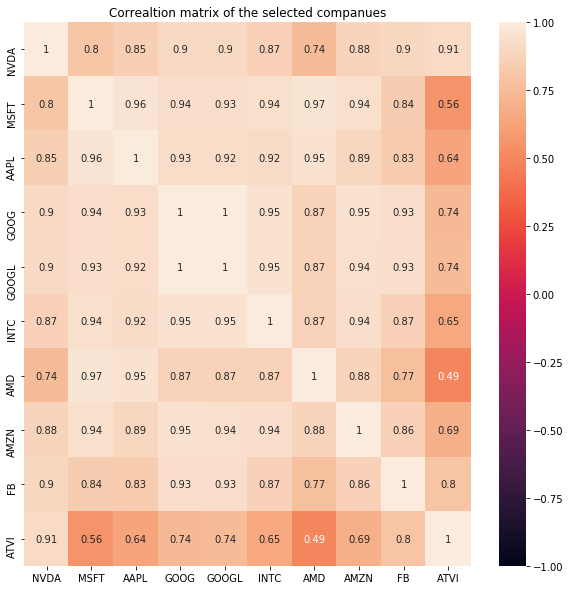

In [6]:
import seaborn as sns 
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),vmin=-1,vmax=1,annot=True)
plt.title('Correlation matrix of the selected companues')

## Transform the dataset for multivariate forecasting 

https://arxiv.org/abs/1910.03002

In [7]:
import gluonts
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset
from gluonts.trainer import Trainer 
from gluonts.model.deepvar import DeepVAREstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.gpvar import GPVAREstimator


In [8]:
# informations and configurations 
freq= 'D'
start_date  = df.index[0]
pred_length = 7

In [9]:
train_ds = ListDataset([{FieldName.TARGET: df.T.values[:,:-pred_length], FieldName.START: start_date}],
                       one_dim_target = False,
                       freq=freq)

test_ds = ListDataset([{FieldName.TARGET: df.T.values[:,:], FieldName.START: start_date}],
                       one_dim_target = False,
                       freq=freq)

In [18]:
# create the model 

estimator = DeepVAREstimator(freq = freq,
                            prediction_length=pred_length,
                            context_length  = 2*pred_length,
                            target_dim=len(list_stock),
                            trainer=Trainer(ctx="cpu", # gpu tend to be slower due to the sequential nature of the algorithm 
                                            epochs=20,
                                            batch_size=32,
                                            learning_rate=3e-3,
                                            hybridize=True,
                                            num_batches_per_epoch=100
                   ))

# estimator = GPVAREstimator(freq = freq,
#                             prediction_length=pred_length,
#                             context_length  = 2*pred_length,
#                             target_dim=len(list_stock),
#                             trainer=Trainer(ctx="gpu",
#                                             epochs=10,
#                                             batch_size=32,
#                                             learning_rate=3e-3,
#                                             hybridize=True,
#                                             num_batches_per_epoch=300
#                    ))

predictor = estimator.train(train_ds)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████████████████████████████████████████| 100/100 [00:02<00:00, 34.89it/s, epoch=20/20, avg_epoch_loss=30.2]


In [19]:
# make the evaluation of the performances 

In [20]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=4096,  # number of sample paths we want for evaluation
)

tss   = list(ts_it)
forecasts = list(forecast_it) 

evaluator = MultivariateEvaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss),
                                      iter(forecasts))

print(json.dumps(agg_metrics, indent=4))

Running evaluation: 1it [00:00, 13.93it/s]
Running evaluation: 1it [00:00, 167.10it/s]
Running evaluation: 1it [00:00, 143.25it/s]
Running evaluation: 1it [00:00, 167.10it/s]
Running evaluation: 1it [00:00, 167.14it/s]
Running evaluation: 1it [00:00, 167.10it/s]
Running evaluation: 1it [00:00, 143.27it/s]
Running evaluation: 1it [00:00, 143.24it/s]
Running evaluation: 1it [00:00, 200.55it/s]
Running evaluation: 1it [00:00, 143.25it/s]


{
    "0_MSE": 1360.440708705357,
    "0_abs_error": 247.20111083984375,
    "0_abs_target_sum": 2487.739990234375,
    "0_abs_target_mean": 355.3914271763393,
    "0_seasonal_error": 1.6740254809677864,
    "0_MASE": 21.09552381799828,
    "0_MAPE": 0.09860803655790422,
    "0_sMAPE": 0.10414510667920863,
    "0_OWA": NaN,
    "0_MSIS": 231.97998250373539,
    "0_QuantileLoss[0.1]": 92.20811767578125,
    "0_Coverage[0.1]": 0.0,
    "0_QuantileLoss[0.5]": 247.20111083984375,
    "0_Coverage[0.5]": 0.0,
    "0_QuantileLoss[0.9]": 107.59384155273438,
    "0_Coverage[0.9]": 0.2857142857142857,
    "0_RMSE": 36.88415254150971,
    "0_NRMSE": 0.10378458713695535,
    "0_ND": 0.09936774414136199,
    "0_wQuantileLoss[0.1]": 0.037065014043969335,
    "0_wQuantileLoss[0.5]": 0.09936774414136199,
    "0_wQuantileLoss[0.9]": 0.04324963299022168,
    "0_mean_wQuantileLoss": 0.05989413039185101,
    "0_MAE_Coverage": 0.4047619047619048,
    "1_MSE": 0.6614242281232562,
    "1_abs_error": 3.958724

<Figure size 720x720 with 0 Axes>

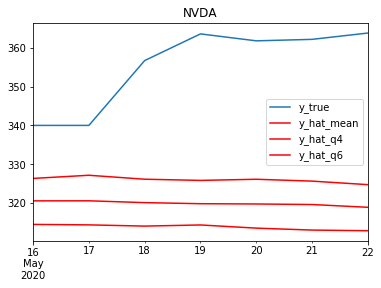

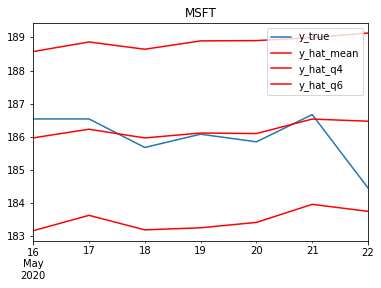

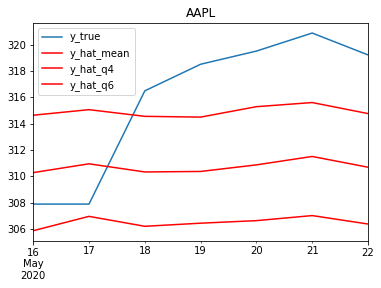

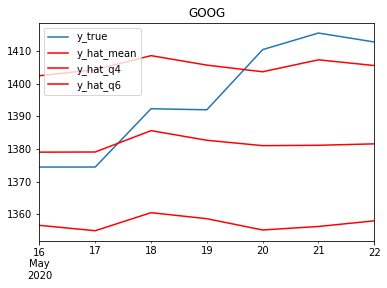

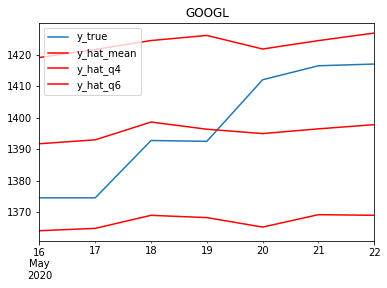

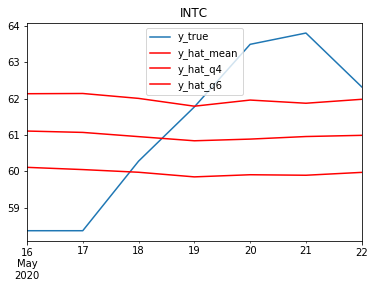

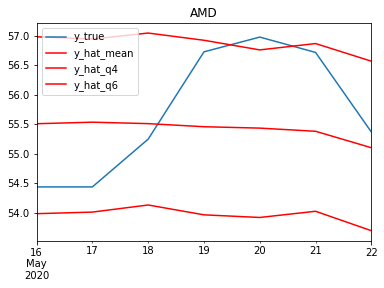

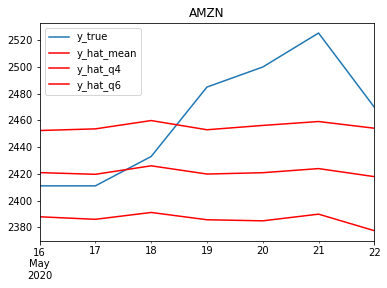

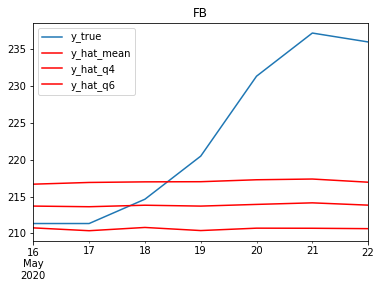

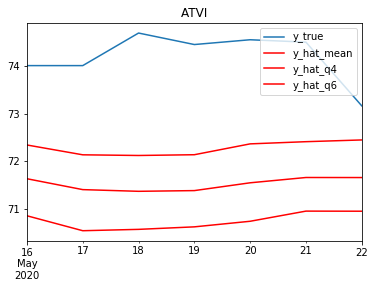

In [21]:
def plot_prob_forecasts(ts_entry, forecast_entry):

    ax = plt.figure(figsize=(10,10))
    df_ts = ts_entry
    df_ts.columns = list_stock
    df_predict_mean = pd.DataFrame(index = forecast_entry.index,
                              columns=list_stock,
                              data=forecast_entry.mean)
    df_predict_q4 = pd.DataFrame(index = forecast_entry.index,
                              columns=list_stock,
                              data=forecast_entry.quantile(.4))
    df_predict_q6 = pd.DataFrame(index = forecast_entry.index,
                              columns=list_stock,
                              data=forecast_entry.quantile(.6))
    
    for i in list_stock:
        plt.figure()
        df_ts[-pred_length:][i].plot(label = 'y_true')
        df_predict_mean[i].plot(label = 'y_hat_mean',c='r')
        df_predict_q4[i].plot(label = 'y_hat_q4',c='r')
        df_predict_q6[i].plot(label = 'y_hat_q6',c='r')
        plt.title(i)
        plt.legend()
    
plot_prob_forecasts(tss[-1], forecasts[-1])